# Traffic Light Recognition - Deep Learning Prototype 
This is a prototype for my Deep Learning Capstone Project on Traffic Light recognition, a part of the Springboard Machine Learning Track.
In this project, I'm attempting to build a complete end to end traffic light detection and recognition system, using the LISA Traffic Light dataset. 

I've documented my initial data exploration in this [notebook](https://github.com/aidandunlop/traffic-lights/blob/master/Data_Exploration.ipynb).

In this notebook, I'll use [pytorch](https://pytorch.org/) to fine tune a pretrained Faster_RCNN model (`fasterrcnn_resnet50_fpn` - trained on the ImageNet database). This [tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) was very helpful in getting things set up.


I'll use [Ax](https://ax.dev/), a library from Facebook Open Source for performing hyperparameter tuning at scale. Recent advances in hyperparameter tuning have led to vast speed and performance improvements, and `Ax` makes these methods easily accessible. We'll use Bayesian Optimization to select the best hyperparameters.

The outcome of this notebook will be the trained model (the weights) and an evaluation of the models performance on a test dataset.

## Running this notebook

This notebook assumes it will have access to the LISA traffic light dataset, and the other python files in [this repository](https://github.com/aidandunlop/traffic-lights/). We'll store the path to the dataset at the beginning of the notebook, so feel free to change the path if it's different on your machine. 

As training takes a considerable amount of time, I've created a script ([`run.sh`](https://github.com/aidandunlop/traffic-lights/blob/master/run.sh)) which will download the dataset from kaggle, unzip and merge into a convenient file structure, and then execute this notebook to train the model using [`papermill`](https://papermill.readthedocs.io/en/latest/). Note that this requires [Kaggle CLI](https://github.com/Kaggle/kaggle-api) credentials, which can be passed in as environment variables.

If you want to run this notebook normally, run ([`get_dataset.sh`](https://github.com/aidandunlop/traffic-lights/blob/master/get_dataset.sh)) (with the same kaggle credentials) before in order to set things up correctly.

## Setup

First let's import the dependencies we need.

In [1]:
import os, sys, glob
import pandas as pd
import numpy as np
import cv2
import torch
import torch.utils.data
import torchvision
import random
import shutil
import math
import time
from PIL import Image
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# import helper functions from pytorch
from engine import train_one_epoch
import engine_utils

# import evaluation library from https://github.com/rafaelpadilla/Object-Detection-Metrics 
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
from Evaluator import Evaluator

# import Ax 
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting

Next let's store the path to the dataset, so we can reuse it later.

In [3]:
dataset_path = '/notebooks/traffic-lights/lisa-traffic-light-dataset'

The annotations for each image are stored in multiple csv files, so let's write a quick function to convert them into a Pandas DataFrame:

In [4]:
def createDataFrame(files):
    df = pd.concat((pd.read_csv(f, ';') for f in files))
    return df

As our dataset is very large, we're going to have to load the data in batches, so let's extend the pytorch [Dataset](https://pytorch.org/docs/stable/data.html#map-style-datasets) class for our dataset. This will be passed to a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) which will allow us to iterate over the dataset efficiently.

In [5]:
# Define class labels
CLASS_LABEL_MAP = {
    'go': 1,
    'goForward': 2,
    'goLeft': 3,
    "warning": 4,
    "warningLeft": 5,
    "stop": 6,
    "stopLeft": 7
}

class LISADataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, bad_images=[]):
        self.root = root
        self.transforms = transforms

        # load all annotation files
        annotationFiles = glob.glob(os.path.join(root, 'Annotations/Annotations', '**/*BOX.csv'), recursive=True)
        self.annotations = createDataFrame(annotationFiles)
        # only load images with associated annotations (i.e. traffic lights). Pytorch's API doesn't accept negative training images.         
        self.imgs = self.annotations['Filename'].str.split('/').str[-1].unique()
        # filter out bad images if there are any
        self.imgs = [img for img in self.imgs if img not in bad_images]
        self.annotations = self.annotations[~self.annotations['Filename'].str.split('/').str[-1].isin(bad_images)]

    # get traffic light annotations for a given frame
    def getBoxAnnotationsForFrame(self, frame_id):
        stripped_filename = self.annotations['Filename'].str.split('/').str[-1]
        annotations = self.annotations.loc[stripped_filename == frame_id]
        return annotations[['Filename', 'Annotation tag', 'Upper left corner X', 'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y']]

    def __getitem__(self, idx):
        # load image at that index
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        annotation = self.getBoxAnnotationsForFrame(self.imgs[idx])
        # get bounding box coordinates for each traffic light
        num_objs = len(annotation)
        boxes = []
        labels = []
        for index, row in annotation.iterrows():
            xmin = row['Upper left corner X']
            xmax = row['Lower right corner X']
            ymin = row['Upper left corner Y']
            ymax = row['Lower right corner Y']
            boxes.append([xmin, ymin, xmax, ymax])
            tag = CLASS_LABEL_MAP[row['Annotation tag']]
            labels.append(CLASS_LABEL_MAP[row['Annotation tag']])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        
        # calculate the area for the bounding boxes         
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if num_objs > 0 else 0
        area = torch.as_tensor(area, dtype=torch.float32)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
        img_name = self.imgs[idx]

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target, img_name

    def __len__(self):
        return len(self.imgs)
    
    def get_height_and_width(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        width, height = Image.open(img_path).size
        return height, width

We might want to transform our images during the training phase to improve the accuracy of our system. To begin with, we won't be applying any additional transforms, but let's set this up in case we want to later.

We can do so by writing a `get_transform` function that is run on each image during processing.

In [6]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

Let's instantiate our training and testing dataset using the class we just created. This won't load the images, but will get them ready to be loaded iteratively. Ensure that this path is an absolute path.

In [7]:
full_dataset = LISADataset(dataset_path, transforms=get_transform())
print('Number of images:', len(full_dataset))

Number of images: 36265


Looks like we have a lot of images to get through! One image can contain multiple traffic lights, so let's see the distribution of traffic light states:

In [8]:
print('Number of annotations (i.e. number of annotated traffic lights):', len(full_dataset.annotations))
print('Annotation counts:')
print(full_dataset.annotations['Annotation tag'].value_counts())

Number of annotations (i.e. number of annotated traffic lights): 109475
Annotation counts:
go             46723
stop           44318
stopLeft       12734
warning         2669
goLeft          2476
warningLeft      350
goForward        205
Name: Annotation tag, dtype: int64


We're going to want to run this on a GPU, to speed up processing times. It can be run on a CPU, but will take too long.

In [9]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Splitting the dataset

We're going to split the dataset into 3 separate subsets - for training, validation, and testing. The training set will be passed directly to the model and the weights will be updated accordingly. The validation set will be used to evaluate the model after each iteration, and update the hyperparameters as needed. The testing set will be used to calculate the performance of the dataset on unseen data, after we have finished training. 

To do this, we're going to take a stratified sample of the dataset. This means that we'll have the same proportion of traffic light states across each of the different subsets. This is important, as if we just take a random sample, we might end up with no examples of certain states for training, or equally we might have no knowledge of evaluation performance if we don't have certain states for testing/validation.

A stratified sample will be a subset of the original sample with the same distribution of traffic light states. However, we're passing in whole images to our model, which could contain any number of traffic lights, so instead of looking at the overall distribution of traffic light states, we should look at the distribution of combinations of traffic light states in an image. We can't perform stratified sampling without at least two examples of a possible combination, as a correct stratified sample wouldn't exist. As we'll be taking two splits (one to split for training and testing, and another to split for training and validation), we'll need at least three.

In [10]:
image_paths = full_dataset.annotations.groupby('Filename')

labels_per_image = image_paths.apply(lambda x: x['Annotation tag'].unique())

In [11]:
# find combinations of traffic lights
label_combinations = [[CLASS_LABEL_MAP[label] for label in labels] for labels in labels_per_image]
unique_combinations, unique_combinations_counts = np.unique(label_combinations, return_counts=True)
print(np.dstack((unique_combinations,unique_combinations_counts)))

[[[list([1]) 11821]
  [list([1, 3]) 863]
  [list([1, 3, 7]) 16]
  [list([1, 4]) 127]
  [list([1, 4, 5]) 55]
  [list([1, 4, 6]) 57]
  [list([1, 4, 7]) 42]
  [list([1, 5]) 108]
  [list([1, 6]) 1730]
  [list([1, 6, 3]) 8]
  [list([1, 6, 7]) 463]
  [list([1, 7]) 3336]
  [list([2]) 70]
  [list([3]) 346]
  [list([3, 2]) 70]
  [list([3, 5]) 1]
  [list([4]) 409]
  [list([4, 5]) 55]
  [list([4, 6]) 158]
  [list([4, 7]) 203]
  [list([5]) 9]
  [list([6]) 9441]
  [list([6, 3]) 570]
  [list([6, 7]) 6164]
  [list([7]) 124]
  [list([7, 2]) 19]]]


In [12]:
# To stratify the dataset correctly, we need each set of classes to have a least three (for val, test and train) samples
# let's see if this is the case 
REVERSED_CLASS_LABEL_MAP = dict((reversed(item) for item in CLASS_LABEL_MAP.items()))

for combo, count in zip(unique_combinations, unique_combinations_counts):
    if count < 3:
        print([REVERSED_CLASS_LABEL_MAP[cls] for cls in combo])

['goLeft', 'warningLeft']


In [13]:
# let's find the example where we have 'goLeft' and 'warningLeft' in an image
goLeftRows = full_dataset.annotations[full_dataset.annotations['Annotation tag'] == 'goLeft']
warningLeftRows = full_dataset.annotations[full_dataset.annotations['Annotation tag'] == 'warningLeft']
goLeftPaths = list(goLeftRows['Filename'])

for index, row in warningLeftRows.iterrows():
    if (row['Filename'] in goLeftPaths):
        img_to_delete = row['Filename'].split('/')[-1]
        print(index, img_to_delete)

856 nightClip3--00172.jpg


It looks like we have one image with a unique combination of traffic lights. We could do some data augmentation here to create more examples of this combination, but to make things simpler, we'll just remove this from our dataset. We have other examples of `goLeft` and `warningLeft` so that shouldn't be a problem.

There's an interesting question here as to whether we should balance our dataset. We don't want the model to be biased towards a particular class just because we provided more examples of that class, but we do want to be representative of the real world. Some traffic lights cases (go) are probably more common than others (goLeft) in reality, so we should allow our dataset to be representative. However, this needs verifying! For now, let's just keep the class proportions the same.

In [14]:
full_dataset = LISADataset(dataset_path, transforms=get_transform(), bad_images=[img_to_delete])
print('Number of images:', len(full_dataset))
print('Number of annotations (i.e. number of annotated traffic lights):', len(full_dataset.annotations))
print('Class counts:')
print(full_dataset.annotations['Annotation tag'].value_counts())


Number of images: 36264
Number of annotations (i.e. number of annotated traffic lights): 109473
Class counts:
go             46723
stop           44318
stopLeft       12734
warning         2669
goLeft          2475
warningLeft      349
goForward        205
Name: Annotation tag, dtype: int64


In [15]:
image_paths = full_dataset.annotations.groupby('Filename')

labels_per_image = image_paths.apply(lambda x: x['Annotation tag'].unique())
# find combinations of traffic lights
label_combinations = [[CLASS_LABEL_MAP[label] for label in labels] for labels in labels_per_image]

Pytorch doesn't contain a Stratified Sampler, but we can extend the base sampler class to create our own. The following stratified Sampler was adapted from [torchsample](https://github.com/ncullen93/torchsample). 

In [16]:
# adapted from torchsample
from torch.utils.data import Sampler
class StratifiedSampler(Sampler):
    """Stratified Sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, class_vector, batch_size, test_size=0.5):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = int(class_vector.size(0) / batch_size)
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        # stratification is done on y, so X doesn't matter here
        X = torch.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index = next(s.split(X, y))
        return (train_index, test_index)

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)


StratifiedShuffleSplit expects each label (in this case the combinations) to be of the same size, so let's pad out the combinations so they are of equal size.

In [17]:
maxLen = max(map(len, label_combinations))
for row in label_combinations:
    while len(row) < maxLen:
        row.append(0)

Let's take a stratified sample of the dataset to run the prototype on (before splitting into training, testing, and validation).

Here we perform stratified sampling, splitting once to get our training and testing sets, and splitting again to get our validation set. 
We then create our dataloaders, which we can use to iterate over the data later.

In [18]:
# For the initial prototype, use 25% of the original dataset - in the future we'd use the full one, but training takes too long.
large_sample_indices, small_sample_indices = list(StratifiedSampler(torch.tensor(label_combinations), 1, test_size=0.25))
small_sample_labels = [label_combinations[index] for index in small_sample_indices]

# perform first split of dataset into training and testing
training_indices, testing_indices  = list(StratifiedSampler(torch.tensor(small_sample_labels), 1, test_size=0.3))

# perform second split of training set into training and validation set
training_labels = [label_combinations[index] for index in training_indices]
training_indices, validation_indices = list(StratifiedSampler(torch.tensor(training_labels), 1, test_size=0.3))

In [19]:
# split data into training and testing, with 70:30 ratio 
training_dataset = torch.utils.data.Subset(full_dataset, training_indices)

testing_dataset = torch.utils.data.Subset(full_dataset, testing_indices)

validation_dataset = torch.utils.data.Subset(full_dataset, validation_indices)

print('Subset sizes')
print('Training: {}, Validation: {}, Testing: {}'.format(len(training_dataset), len(validation_dataset), len(testing_dataset)))

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    training_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=engine_utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    testing_dataset, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=engine_utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    validation_dataset, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=engine_utils.collate_fn)

Subset sizes
Training: 4442, Validation: 1904, Testing: 2720


Let's see the distribution of classes across our three subsets:

In [20]:
df = pd.DataFrame({'filename':labels_per_image.index, 'classes':labels_per_image.values})
train_df = df.take(training_indices)
test_df = df.take(testing_indices)
val_df = df.take(validation_indices)
print('Train:\n{}\n'.format(train_df.classes.explode().value_counts()))
print('Test:\n{}\n'.format(test_df.classes.explode().value_counts()))
print('Validation:\n{}\n'.format(val_df.classes.explode().value_counts()))

Train:
go             2147
stop           2119
stopLeft        782
warning         105
goForward       103
goLeft           49
warningLeft      34
Name: classes, dtype: int64

Test:
stop           1554
go             1113
stopLeft        482
goLeft          100
warning          54
goForward        51
warningLeft      14
Name: classes, dtype: int64

Validation:
go             932
stop           879
stopLeft       352
warning         57
goForward       56
goLeft          34
warningLeft     19
Name: classes, dtype: int64



Looks good!

To evaluate the model, we'll use this great [Object Detection Evaluation Library](https://github.com/rafaelpadilla/Object-Detection-Metrics/). This comes with built in classes for building up collections of bounding boxes, and will perform evaluation based on the PASCAL VOC Challenge. Mean Average Precision (mAP) is a great metric to sum up the performance of an object detector, so we'll extract that and used that to improve our hyperparameters.
Let's create a function to iterate through one of our data loaders and create the bounding boxes we need, depending on whether we're using ground truth files or the model's predictions.

In [21]:
def create_bounding_boxes(data_loader, bb_type, model, ground_truth_bb = None):
    is_detection = bb_type == BBType.Detected
    if is_detection and ground_truth_bb is not None:
        model.eval()
        bounding_boxes = ground_truth_bb
    elif is_detection:
        raise Exception('please provide ground truth bounding boxes.')
    else:
        bounding_boxes = BoundingBoxes()

    for images, targets, image_names in data_loader:
        if is_detection:
            images = list(img.to(device) for img in images)
            annotations = model(images)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        else:
            annotations = [{k: v.to(device) for k, v in t.items()} for t in targets]

        for annotation, image_name in zip(annotations, image_names):
            boxes = annotation['boxes'].tolist()
            labels = annotation['labels'].tolist()
            scores = annotation['scores'].tolist() if 'scores' in annotation else None
            items = zip(boxes, labels, scores) if is_detection else zip(boxes, labels)

            for item in items:
                if is_detection: box, label, score = item
                else: box, label = item

                x1, y1, x2, y2 = box
                bounding_box_args = { 'imageName': image_name, 'classId': label,
                    'x': x1, 'y': y1, 'w': x2, 'h': y2,
                    'typeCoordinates': CoordinatesType.Absolute,
                    'bbType': bb_type, 'format': BBFormat.XYX2Y2
                }
                if is_detection: bounding_box_args['classConfidence'] = score
                bb = BoundingBox(**bounding_box_args)
                bounding_boxes.addBoundingBox(bb)

    return bounding_boxes

We can then create an `evaluate` function, which given a dataloader, will return the metrics for that particular dataset. We'll use this during training on our validation set to update the hyperparameters, and during testing to produce our final `mean accuracy precision` score.

In [22]:
def evaluate(model, data_loader, device, ground_truth_bb):
    all_bb = create_bounding_boxes(data_loader, BBType.Detected, model, ground_truth_bb)
    
    evaluator = Evaluator()
    metrics = evaluator.GetPascalVOCMetrics(all_bb)
    print('Average precision per class:')
    for metric in metrics:
        c = metric['class']
        # Get metric values per each class
        average_precision = metric['AP']
        # Print AP per class
        print('%s: %f' % (c, average_precision))
    return metrics

## Fine tuning

Now we can get the Faster RCNN Predictor from pytorch, reading for fine tuning. Let's write a function to return us our model (so we can easily swap it out later if we desire).

Here we get the pretrained ResNet50 model, and fit a new predictor on top, with the correct number of classes.

In [23]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

Our dataset has seven classes that we want to detect. Pytorch's object detection API counts the background as another class, so we need to tell pytorch about eight classes. Here we declare the number of target classes, and get our model using our helper function.

Let's get the bounding boxes from the validation set now, so we can use them during the training process.

In [24]:
validation_ground_truth = create_bounding_boxes(data_loader_val, BBType.GroundTruth, model=None)

I used `Ax` to tune the hyperparamters to the model. Ax will run trials across the training process, with each trial being a different set of hyperparameters. Ax requires a `evaluation function`, which will run on each trial. To make things simple, we'll try to optimize the `number of epochs` needed and the `learning rate`. We then get the `mean average precision` for a trial, and Ax will perform bayesian optimization iteratively and extract the best hyperparameters.

In [25]:
num_classes = len(CLASS_LABEL_MAP) + 1

def train_evaluate(parameterization):
        model = get_model(num_classes)
        model.to(device)
        epochs = parameterization['num_epochs']
        learning_rate = parameterization['lr']
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        print('Using lr={} and num_epochs={}'.format(learning_rate, epochs))
        for epoch in range(epochs):
            train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
        
        evaluation = evaluate(model, data_loader_val, device, validation_ground_truth)
        precisions = [0 if np.isnan(metric['AP']) else metric['AP'] for metric in evaluation]
        mean_average_precision = np.sum(precisions) / len(CLASS_LABEL_MAP)
        print('mAP:', mean_average_precision)
        torch.save(model.state_dict(), 'model_lr_{}_epochs_{}.pth'.format(learning_rate, epochs))
        torch.save(model.state_dict(), '/artifacts/model_lr_{}_epochs_{}.pth'.format(learning_rate, epochs))
        return mean_average_precision

I've left the code in here to show how I performed hyperparameter tuning. I only did this across a few trials to speed up the training process, and I was happy with the performance. However, I would like to come back at some point and do more trials with greater range of hyperparameters, to see how much I can improve the performance. 

In [25]:
best_parameters, values, experiment, ax_model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.01], "log_scale": True},
        {"name": "num_epochs", "type": "choice", "values": list(range(1,5))},
    ],
    evaluation_function=train_evaluate,
    objective_name='mean_average_precision',
    total_trials=4
)

[INFO 03-17 16:44:33] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-17 16:44:33] ax.service.managed_loop: Started full optimization with 4 steps.
[INFO 03-17 16:44:33] ax.service.managed_loop: Running optimization trial 1...
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



Using lr=0.000453864935942075 and num_epochs=4


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2522: UserWarning:

The default behavior for interpolate/upsample with float scale_factor will change in 1.5.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 

/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:1334: UserWarning:

This overload of add_ is deprecated:
add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
add_(Tensor other, Number alpha)

/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:1550: UserWarning:

This overload of addcmul_ is deprecated:
addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
addcmul_(Tensor tensor1, Tensor tensor2, Number value)

/pytorch/torch/csrc/autograd/gener

Epoch: [0]  [   0/2221]  eta: 1:13:08  lr: 0.000454  time: 1.9760  data: 1.1799  max mem: 2137
Epoch: [0]  [1000/2221]  eta: 0:20:58  lr: 0.000454  time: 1.0307  data: 0.0093  max mem: 2562
Epoch: [0]  [2000/2221]  eta: 0:03:47  lr: 0.000454  time: 1.0258  data: 0.0092  max mem: 2562
Epoch: [0]  [2220/2221]  eta: 0:00:01  lr: 0.000454  time: 1.0262  data: 0.0096  max mem: 2562
Epoch: [0] Total time: 0:38:07 (1.0299 s / it)
Epoch: [1]  [   0/2221]  eta: 1:10:52  lr: 0.000454  time: 1.9146  data: 1.2028  max mem: 2562
Epoch: [1]  [1000/2221]  eta: 0:20:55  lr: 0.000454  time: 1.0285  data: 0.0091  max mem: 2562
Epoch: [1]  [2000/2221]  eta: 0:03:47  lr: 0.000454  time: 1.0252  data: 0.0093  max mem: 2562
Epoch: [1]  [2220/2221]  eta: 0:00:01  lr: 0.000454  time: 1.0305  data: 0.0094  max mem: 2562
Epoch: [1] Total time: 0:38:01 (1.0275 s / it)
Epoch: [2]  [   0/2221]  eta: 1:21:31  lr: 0.000454  time: 2.2026  data: 1.4977  max mem: 2562
Epoch: [2]  [1000/2221]  eta: 0:20:55  lr: 0.000454

[INFO 03-17 19:23:59] ax.service.managed_loop: Running optimization trial 2...


Using lr=2.3127645446353686e-06 and num_epochs=1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2522: UserWarning:

The default behavior for interpolate/upsample with float scale_factor will change in 1.5.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 



Epoch: [0]  [   0/2221]  eta: 1:10:27  lr: 0.000002  time: 1.9034  data: 1.1376  max mem: 3180
Epoch: [0]  [1000/2221]  eta: 0:20:56  lr: 0.000002  time: 1.0281  data: 0.0090  max mem: 3180
Epoch: [0]  [2000/2221]  eta: 0:03:47  lr: 0.000002  time: 1.0292  data: 0.0095  max mem: 3180
Epoch: [0]  [2220/2221]  eta: 0:00:01  lr: 0.000002  time: 1.0296  data: 0.0093  max mem: 3180
Epoch: [0] Total time: 0:38:05 (1.0290 s / it)
Average precision per class:
1: 0.869377
3: 0.907840
4: 0.721648
5: 1.000000
6: 0.800958
7: 0.869560
mAP: 0.7384833176960541


[INFO 03-17 20:09:17] ax.service.managed_loop: Running optimization trial 3...


Using lr=0.00042288207093198784 and num_epochs=2


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2522: UserWarning:

The default behavior for interpolate/upsample with float scale_factor will change in 1.5.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 



Epoch: [0]  [   0/2221]  eta: 1:11:49  lr: 0.000423  time: 1.9403  data: 1.1759  max mem: 3180
Epoch: [0]  [1000/2221]  eta: 0:20:57  lr: 0.000423  time: 1.0282  data: 0.0089  max mem: 3180
Epoch: [0]  [2000/2221]  eta: 0:03:47  lr: 0.000423  time: 1.0258  data: 0.0087  max mem: 3180
Epoch: [0]  [2220/2221]  eta: 0:00:01  lr: 0.000423  time: 1.0256  data: 0.0090  max mem: 3180
Epoch: [0] Total time: 0:38:03 (1.0282 s / it)
Epoch: [1]  [   0/2221]  eta: 1:10:11  lr: 0.000423  time: 1.8961  data: 1.1947  max mem: 3180
Epoch: [1]  [1000/2221]  eta: 0:20:54  lr: 0.000423  time: 1.0252  data: 0.0090  max mem: 3180
Epoch: [1]  [2000/2221]  eta: 0:03:47  lr: 0.000423  time: 1.0264  data: 0.0089  max mem: 3180
Epoch: [1]  [2220/2221]  eta: 0:00:01  lr: 0.000423  time: 1.0257  data: 0.0091  max mem: 3180
Epoch: [1] Total time: 0:38:01 (1.0271 s / it)
Average precision per class:
1: 0.643852
3: 0.879844
4: 0.789534
5: 1.000000
6: 0.665002
7: 0.713952
mAP: 0.6703120749060435


[INFO 03-17 21:32:36] ax.service.managed_loop: Running optimization trial 4...


Using lr=3.940697221375912e-06 and num_epochs=1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2522: UserWarning:

The default behavior for interpolate/upsample with float scale_factor will change in 1.5.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 



Epoch: [0]  [   0/2221]  eta: 1:21:32  lr: 0.000004  time: 2.2028  data: 1.4407  max mem: 3180
Epoch: [0]  [1000/2221]  eta: 0:20:57  lr: 0.000004  time: 1.0299  data: 0.0087  max mem: 3180
Epoch: [0]  [2000/2221]  eta: 0:03:47  lr: 0.000004  time: 1.0284  data: 0.0091  max mem: 3180
Epoch: [0]  [2220/2221]  eta: 0:00:01  lr: 0.000004  time: 1.0284  data: 0.0089  max mem: 3180
Epoch: [0] Total time: 0:38:05 (1.0292 s / it)
Average precision per class:
1: 0.609709
3: 0.881338
4: 0.789442
5: 1.000000
6: 0.615490
7: 0.670699
mAP: 0.652382652120033


In [26]:
print('Best params:', best_parameters)
print('yields', values)

Best params: {'lr': 0.000453864935942075, 'num_epochs': 4}
yields ({'mean_average_precision': 0.7671497470750371}, {'mean_average_precision': {'mean_average_precision': 0.0}})


The best parameters I found were a learning rate of 6.863259765402522e-06, with 2 epochs. I'm sure I can find better, but let's see how well that does for now.

In [ ]:
best_params = {'lr': 0.000453864935942075, 'num_epochs': 4}
best_mAP = train_evaluate(best_params)

Using lr=0.000453864935942075 and num_epochs=4


/pytorch/torch/csrc/utils/python_arg_parser.cpp:748: UserWarning:

This overload of nonzero is deprecated:
	nonzero(Tensor input, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, bool as_tuple)



Epoch: [0]  [   0/2221]  eta: 1:12:22  lr: 0.000454  time: 1.9553  data: 1.1664  max mem: 2138
Epoch: [0]  [1000/2221]  eta: 0:20:48  lr: 0.000454  time: 1.0214  data: 0.0090  max mem: 2562
Epoch: [0]  [2000/2221]  eta: 0:03:45  lr: 0.000454  time: 1.0206  data: 0.0090  max mem: 2562
Epoch: [0]  [2220/2221]  eta: 0:00:01  lr: 0.000454  time: 1.0209  data: 0.0091  max mem: 2562
Epoch: [0] Total time: 0:37:50 (1.0222 s / it)
Epoch: [1]  [   0/2221]  eta: 1:12:14  lr: 0.000454  time: 1.9516  data: 1.2476  max mem: 2562
Epoch: [1]  [1000/2221]  eta: 0:20:47  lr: 0.000454  time: 1.0225  data: 0.0090  max mem: 2562
Epoch: [1]  [2000/2221]  eta: 0:03:45  lr: 0.000454  time: 1.0204  data: 0.0090  max mem: 2562
Epoch: [1]  [2220/2221]  eta: 0:00:01  lr: 0.000454  time: 1.0192  data: 0.0095  max mem: 2562
Epoch: [1] Total time: 0:37:48 (1.0213 s / it)
Epoch: [2]  [   0/2221]  eta: 1:11:38  lr: 0.000454  time: 1.9353  data: 1.2323  max mem: 2562
Epoch: [2]  [1000/2221]  eta: 0:20:47  lr: 0.000454

# Evaluation

Now that we've trained our model, we'll want to evaluate it's performance on our test set. 

Let's define some helper functions to visualize the predictions on a test image:

In [30]:
colourMap = {
    'go': (0, 255, 0), 
    'goForward': (0, 255, 0), 
    'goLeft': (0, 255, 0), 
    'warning': (255, 127, 0), 
    'warningLeft': (255, 127, 0), 
    'stop': ( 255, 0, 0), 
    'stopLeft': ( 255, 0, 0)
}

def get_prediction(img, model, threshold):
    pred = model([img.to(device)])
    pred_class = [REVERSED_CLASS_LABEL_MAP[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].cpu().detach().numpy())]
    pred_score = list(pred[0]['scores'].cpu().detach().numpy())
    print('predicted labels:', pred_class)
    print('predicted scores:', pred[0]['scores'].tolist())
    accepted_scores = [pred_score.index(x) for x in pred_score if x > threshold]
    if len(accepted_scores) <= 0:
        return ([],[])
    
    pred_t = accepted_scores[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

def plot_detection(image, model, threshold=0.5, rect_th=1, text_size=1, text_th=2):
    boxes, pred_cls = get_prediction(image, model, threshold) # Get predictions
    img = image.permute(1, 2, 0).numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box, classname in zip(boxes,pred_cls):
        min_coord = tuple(map(int, box[0]))
        max_coord = tuple(map(int, box[1]))
        light_color = colourMap[classname]
        text_location = (min_coord[0], min_coord[1] - 10)

        cv2.rectangle(img, min_coord, max_coord, light_color, rect_th)
        cv2.putText(img, classname, text_location, cv2.FONT_HERSHEY_SIMPLEX, text_size, light_color, thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

We'll now visualize the performance of our model on some random test images, and evaluate the performance on the test dataset as a whole. We'll use a confidence score threshold of 80%, so any objects that were detected with lower confidence than 80% won't be shown.

model_lr_0.000453864935942075_epochs_4.pth
showing detection for daySequence2--01200.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted labels: ['go', 'stopLeft', 'stopLeft', 'stop', 'stop', 'go', 'stopLeft', 'go', 'stop']
predicted scores: [0.9976915121078491, 0.7374716997146606, 0.24644675850868225, 0.07889753580093384, 0.07533270865678787, 0.0636683851480484, 0.06294477730989456, 0.06237635388970375, 0.05136638134717941]


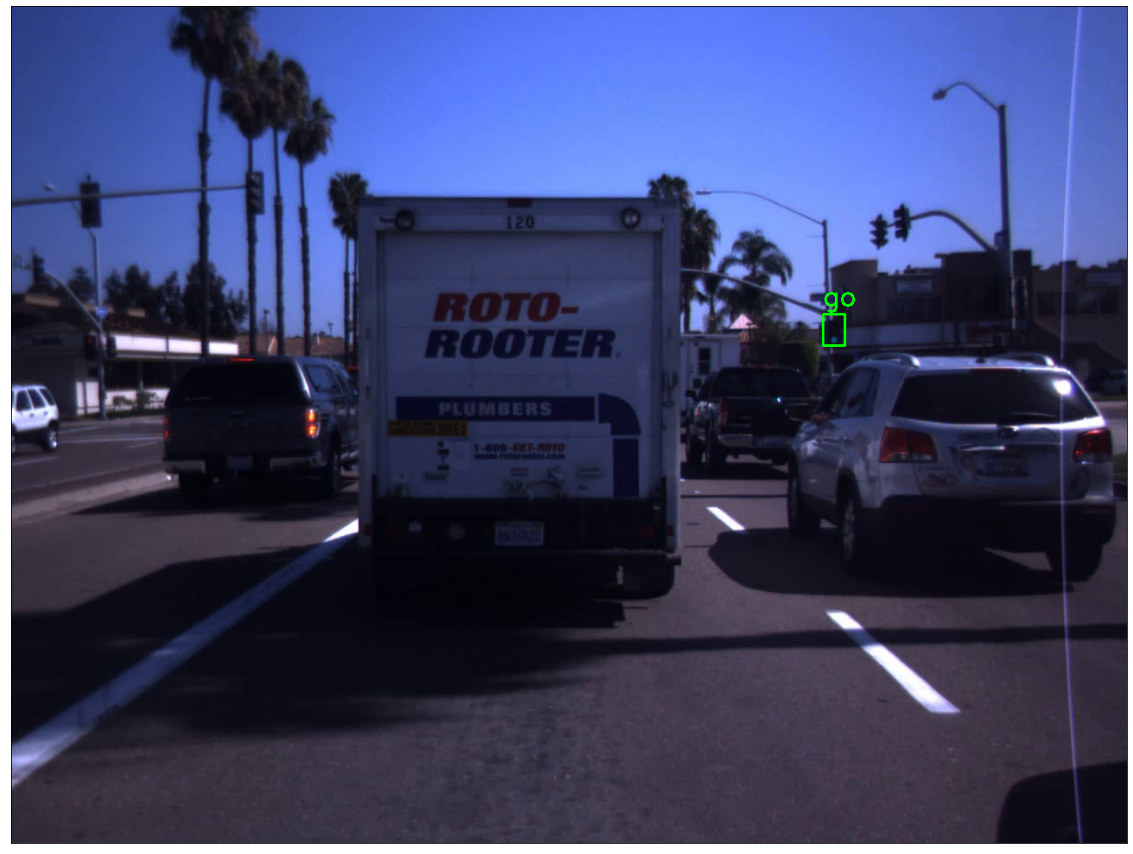

showing detection for daySequence2--05725.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted labels: ['stop', 'stopLeft', 'stopLeft', 'stop', 'stopLeft', 'stop', 'stop', 'stop', 'stop', 'go', 'stopLeft']
predicted scores: [0.9961812496185303, 0.9921493530273438, 0.9879690408706665, 0.9879321455955505, 0.5144738554954529, 0.3230762183666229, 0.21745240688323975, 0.11395111680030823, 0.09828414767980576, 0.09436206519603729, 0.07300500571727753]


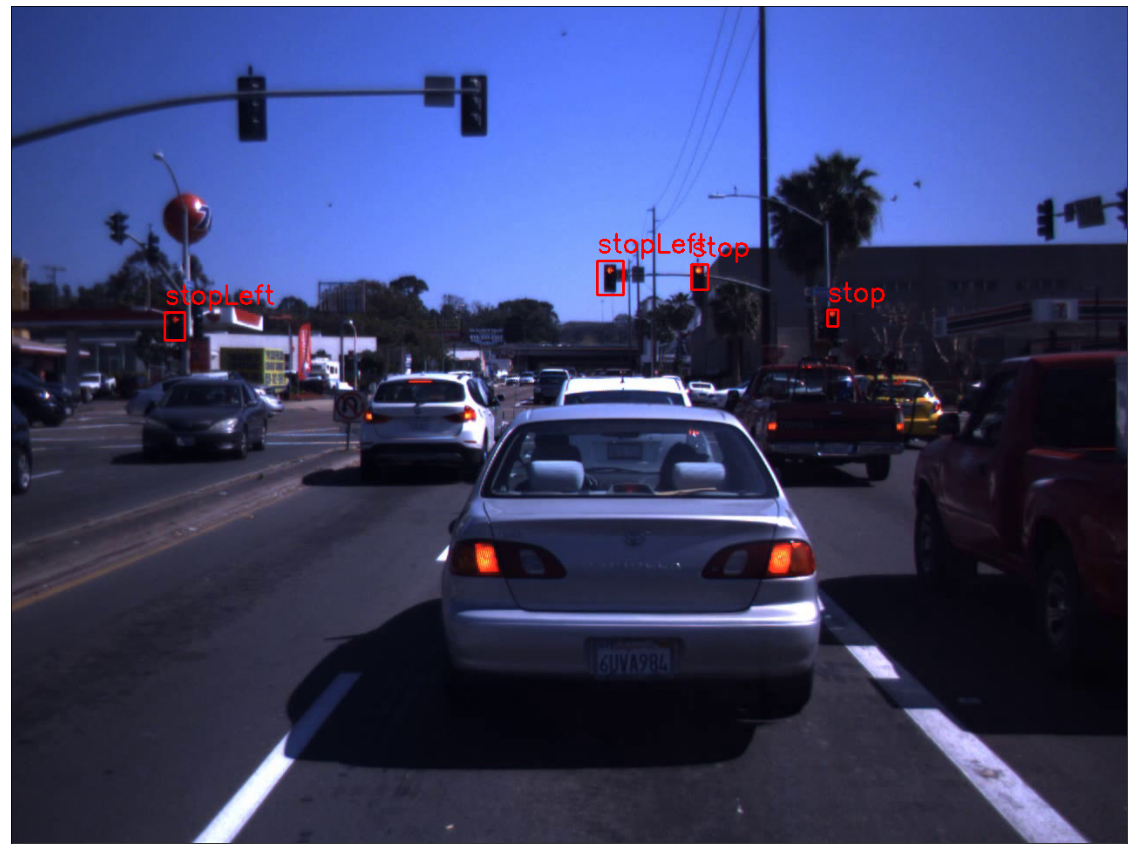

showing detection for daySequence1--00636.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted labels: ['stop', 'stop', 'stop', 'go', 'stop', 'stop', 'stopLeft', 'stopLeft', 'stopLeft']
predicted scores: [0.990683913230896, 0.9622889757156372, 0.9309705495834351, 0.6099867224693298, 0.5998696088790894, 0.5023539662361145, 0.2846567928791046, 0.18721619248390198, 0.05598653480410576]


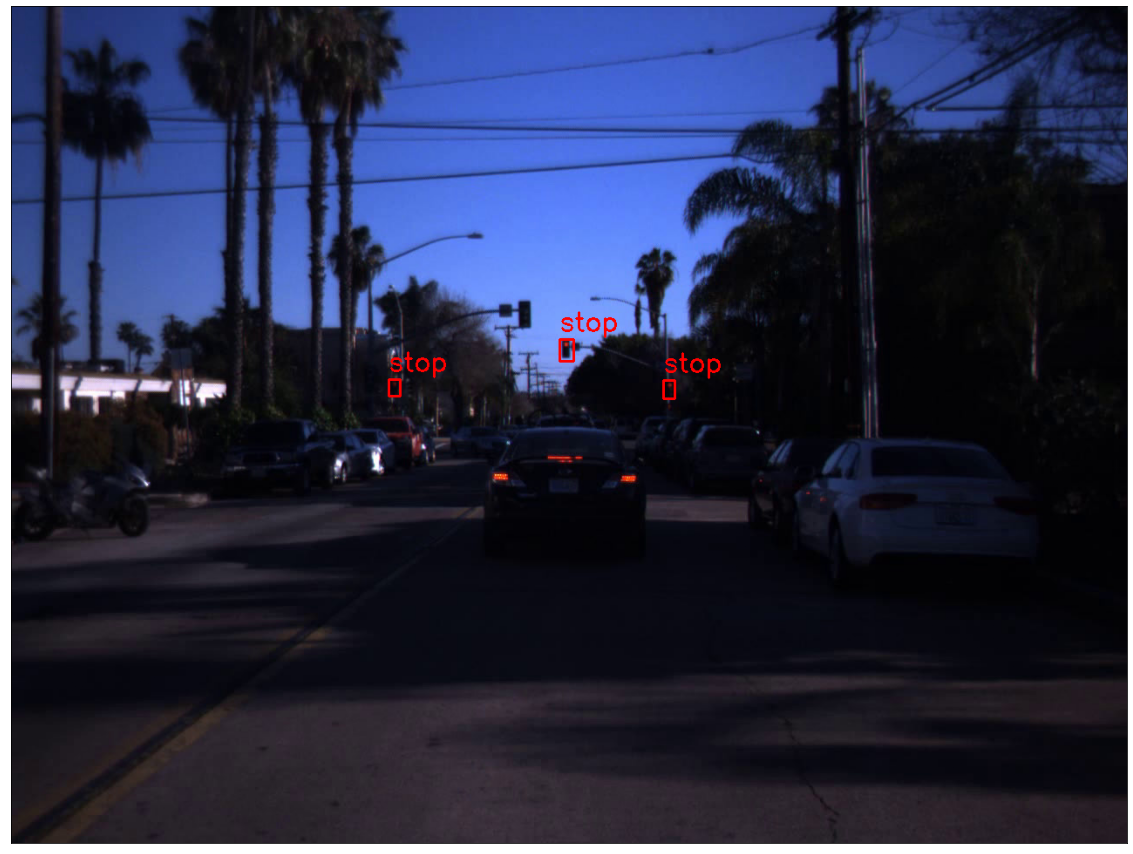

showing detection for daySequence1--01903.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted labels: ['warning', 'warning', 'warning', 'warning', 'go', 'go', 'warning', 'stop', 'go', 'warningLeft', 'warning', 'warningLeft', 'go', 'go', 'go', 'warningLeft', 'go', 'goForward', 'go']
predicted scores: [0.9939442276954651, 0.986879289150238, 0.984551727771759, 0.9547969102859497, 0.6335615515708923, 0.4698748290538788, 0.4467470049858093, 0.16293802857398987, 0.14717835187911987, 0.14459228515625, 0.1385786086320877, 0.13131138682365417, 0.12392441183328629, 0.11324640363454819, 0.0759638249874115, 0.06068975105881691, 0.06023399159312248, 0.05345122888684273, 0.05114811286330223]


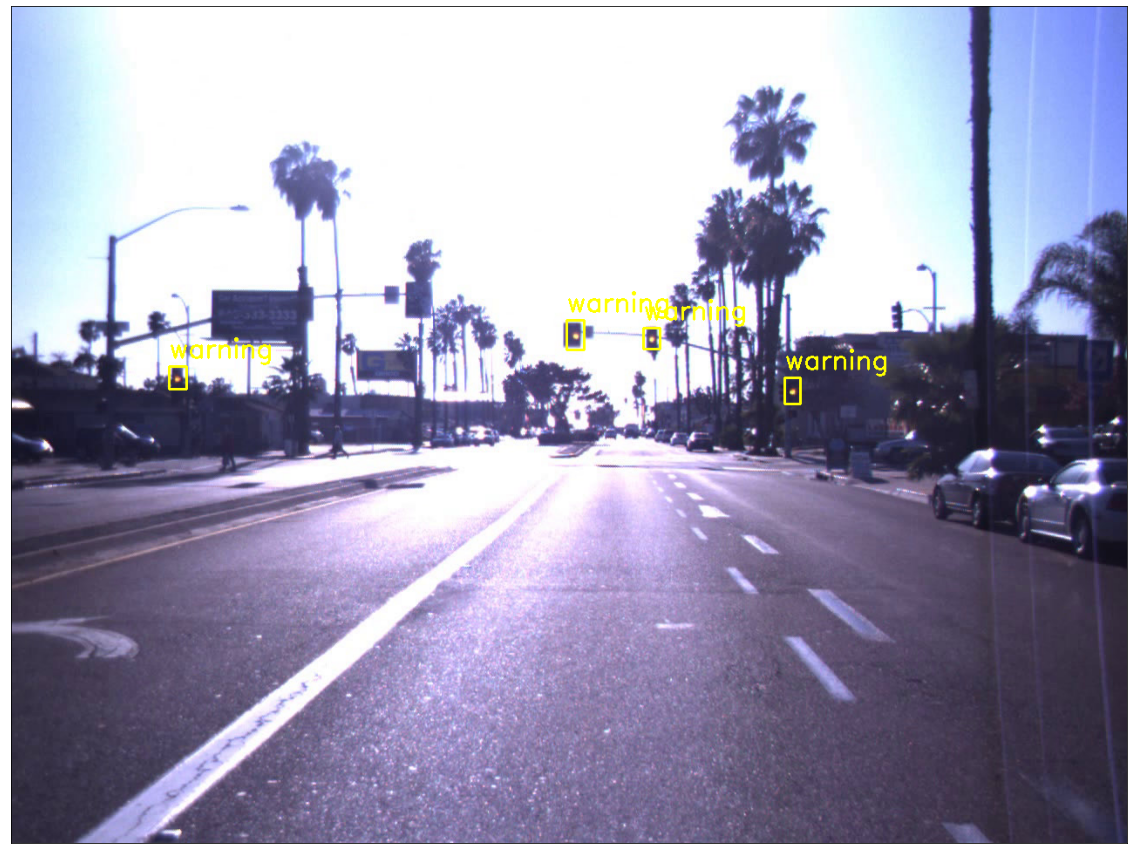

showing detection for dayClip1--00386.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted labels: ['stop', 'stop', 'stop', 'go', 'stopLeft', 'stop', 'go', 'go', 'stopLeft', 'stopLeft', 'stop', 'stop', 'warningLeft', 'stop', 'warningLeft', 'go', 'warningLeft', 'stopLeft', 'goLeft', 'stopLeft', 'go', 'goLeft', 'goForward', 'stopLeft', 'stopLeft', 'warningLeft', 'goLeft', 'warning', 'goLeft', 'stopLeft', 'go', 'go', 'stop', 'warningLeft', 'stop', 'goLeft']
predicted scores: [0.9807165265083313, 0.9668749570846558, 0.9435957670211792, 0.8376641869544983, 0.8363946676254272, 0.6767345070838928, 0.675495445728302, 0.6561143398284912, 0.5858493447303772, 0.5526241660118103, 0.5046074986457825, 0.5022327303886414, 0.49703484773635864, 0.4155511260032654, 0.39527177810668945, 0.2816702127456665, 0.2442251741886139, 0.21405045688152313, 0.10948814451694489, 0.09955772012472153, 0.09310763329267502, 0.0884970873594284, 0.08583784848451614, 0.08511405438184738, 0.0812293216586113, 0.08058971911668777, 0.071833536028862, 0.06867720931768417, 0.068151094019413, 0.06749979406595

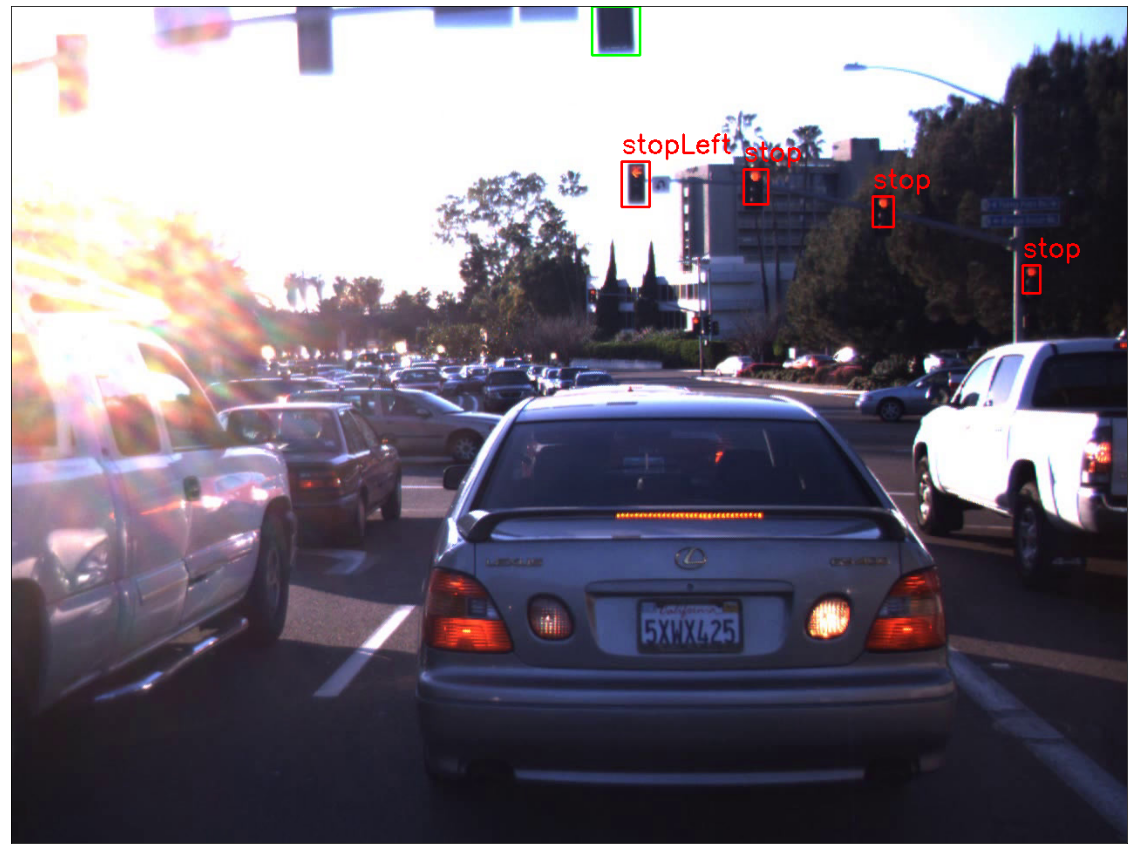

In [38]:
path_to_best_model = 'model_lr_{}_epochs_{}.pth'.format(best_params['lr'], best_params['num_epochs'])
print(path_to_best_model)

model = get_model(num_classes)
model.to(device)

images_path = os.path.join(dataset_path, 'images')

if os.path.exists(path_to_best_model):
    model.load_state_dict(torch.load(path_to_best_model))
    model.eval()
    data_iterator = iter(data_loader_test)
    for i in range(5):        
        image, label, filename = [ x[0] for x in next(data_iterator) ]
        print('showing detection for', filename)
        plot_detection(image, model, 0.8, rect_th=2)


In [34]:
print('creating testing ground truth boxes...')
testing_ground_truth = create_bounding_boxes(data_loader_test, BBType.GroundTruth, model)
# evaluate against test dataset
print('getting evaluation scores...')
evaluation = evaluate(model, data_loader_test, device, testing_ground_truth)

creating testing ground truth boxes...
getting evaluation scores...
Average precision per class:
1: 0.893419
2: 0.836708
3: 0.174309
4: 0.951144
5: 0.691168
6: 0.943428
7: 0.950727


In [36]:
precisions = [0 if np.isnan(metric['AP']) else metric['AP'] for metric in evaluation]
mean_average_precision = np.sum(precisions) / len(CLASS_LABEL_MAP)
print('Mean average precision:', mean_average_precision)

Mean average precision: 0.7772718585150674


## Conclusion

The model seems to do a good job on the testing dataset. In some cases, it finds traffic lights that are hard to see, or far away.

It's likely that it won't perform as well in production as it's only been trained on driving sequences from California, and other states/ or countries have slightly different traffic light variations. Below I've found some examples of UK traffic lights and shown how well the model performs:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted labels: ['go', 'go', 'stopLeft', 'stop', 'stop', 'stop', 'stopLeft', 'stopLeft', 'stopLeft', 'stopLeft', 'stopLeft', 'go', 'go', 'stopLeft', 'stop', 'stopLeft', 'go', 'goLeft', 'go', 'warningLeft', 'stop', 'go', 'goLeft', 'stop', 'goForward', 'stopLeft', 'stop', 'stopLeft', 'warningLeft', 'go', 'goForward', 'goLeft', 'go', 'warningLeft', 'warningLeft', 'stopLeft', 'warningLeft', 'warningLeft', 'goLeft', 'stopLeft', 'go', 'stopLeft', 'stop', 'goLeft', 'warningLeft', 'goLeft', 'stop', 'go', 'goLeft', 'warningLeft', 'warningLeft', 'stopLeft', 'goForward']
predicted scores: [0.9952894449234009, 0.9783073663711548, 0.9661255478858948, 0.9547220468521118, 0.929992139339447, 0.9218654036521912, 0.8477429151535034, 0.7769057750701904, 0.6350141167640686, 0.616722047328949, 0.4462784230709076, 0.42695868015289307, 0.3330003023147583, 0.3319758176803589, 0.3200327754020691, 0.3163498044013977, 0.3115916848182678, 0.3003089427947998, 0.2985984683036804, 0.29644718766212463, 0.2962900698

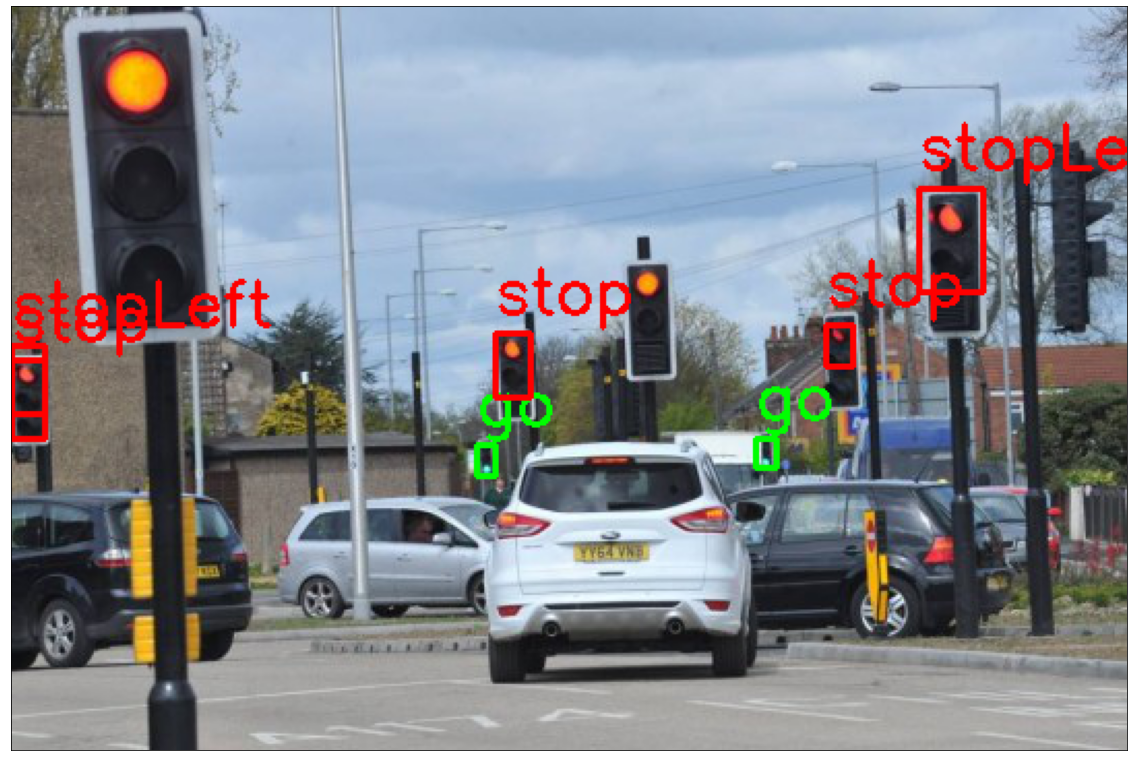

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted labels: ['stop', 'stop', 'stop', 'stopLeft', 'stop', 'stopLeft', 'stop', 'stop', 'goLeft', 'warning', 'stop', 'stopLeft', 'stop', 'goForward', 'warningLeft', 'goLeft', 'stopLeft', 'warningLeft', 'stopLeft', 'stopLeft', 'goLeft', 'stopLeft', 'goForward', 'stopLeft', 'goLeft', 'warning', 'warningLeft', 'goForward', 'stop']
predicted scores: [0.9338411092758179, 0.8995875716209412, 0.7658769488334656, 0.6256773471832275, 0.5991463661193848, 0.5863924026489258, 0.5751467347145081, 0.48199668526649475, 0.42687639594078064, 0.3308946192264557, 0.32495102286338806, 0.2726752460002899, 0.23926831781864166, 0.23019194602966309, 0.2269199639558792, 0.2143370807170868, 0.18771004676818848, 0.1809745728969574, 0.17489659786224365, 0.16650381684303284, 0.15464170277118683, 0.14422348141670227, 0.13789044320583344, 0.08242970705032349, 0.07845064997673035, 0.06800667196512222, 0.06639841198921204, 0.058408673852682114, 0.051899805665016174]


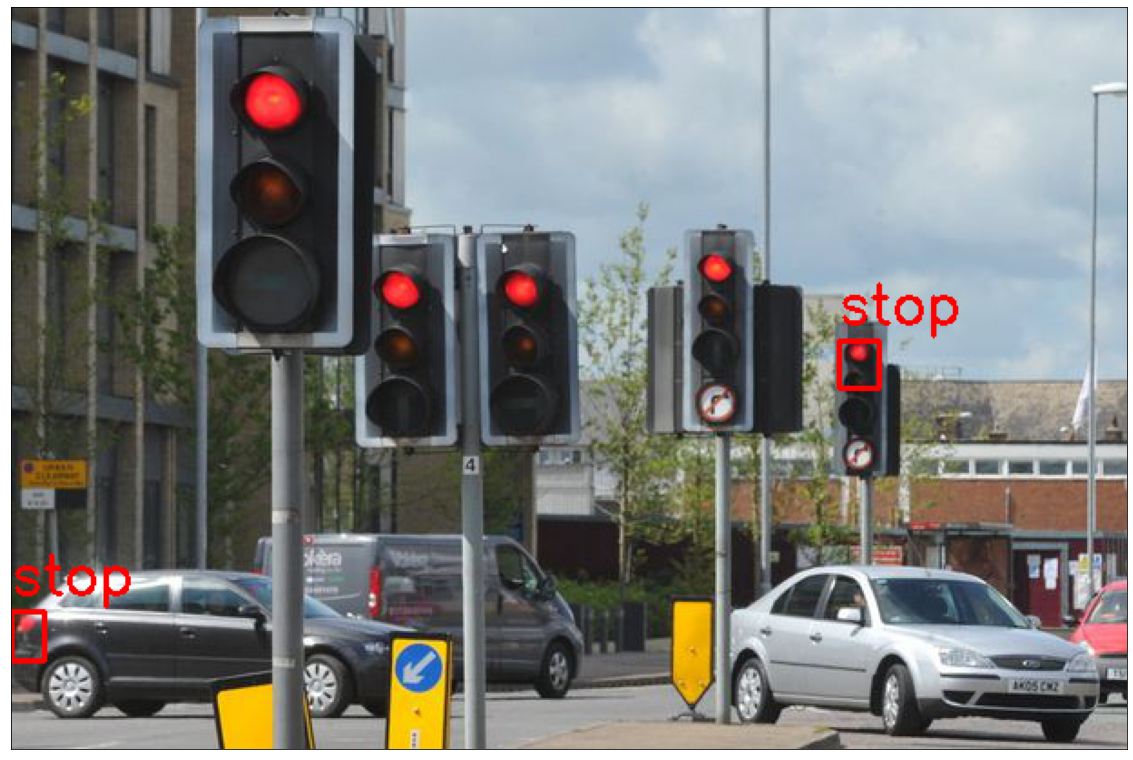

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted labels: ['go', 'go', 'go', 'go', 'go', 'goForward', 'go', 'goLeft', 'go', 'goForward', 'go', 'goLeft', 'go', 'go', 'go', 'go', 'goLeft', 'goLeft', 'go', 'go', 'go', 'go', 'stopLeft', 'go', 'go', 'go', 'stopLeft', 'go', 'go', 'go', 'stop', 'stopLeft', 'warning']
predicted scores: [0.9546438455581665, 0.846203625202179, 0.7699940204620361, 0.7426068186759949, 0.6304357647895813, 0.5798954963684082, 0.5238351225852966, 0.4544665813446045, 0.44513916969299316, 0.3223285377025604, 0.2836725413799286, 0.2809021472930908, 0.2106025367975235, 0.20654259622097015, 0.1609107255935669, 0.15204425156116486, 0.13705120980739594, 0.1194915920495987, 0.095387302339077, 0.09348133951425552, 0.08503967523574829, 0.08034224808216095, 0.07993122935295105, 0.07605776190757751, 0.0758497342467308, 0.0720253512263298, 0.06888137757778168, 0.06682170182466507, 0.06666693836450577, 0.0653148889541626, 0.06073062866926193, 0.05482814833521843, 0.05439703166484833]


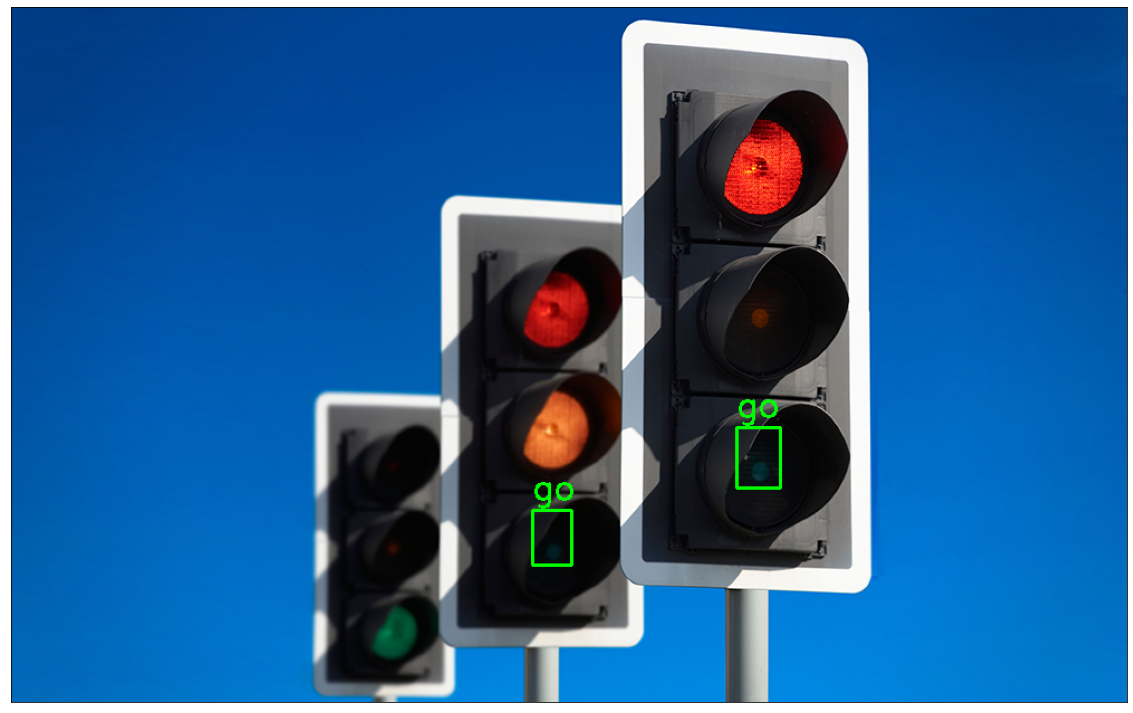

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted labels: ['go', 'go', 'goForward', 'go', 'go', 'go', 'go', 'go', 'go', 'stop', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'stopLeft', 'go', 'go', 'go', 'go', 'go', 'go', 'stop', 'goLeft', 'go', 'go', 'go', 'go', 'go', 'goLeft', 'go', 'go', 'go', 'go', 'goForward', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
predicted scores: [0.89151531457901, 0.6589534282684326, 0.6122909188270569, 0.5474347472190857, 0.5422776341438293, 0.4376733899116516, 0.4257277250289917, 0.41456881165504456, 0.40097731351852417, 0.3961962163448334, 0.37340590357780457, 0.3633415699005127, 0.34799107909202576, 0.3419840335845947, 0.3224952518939972, 0.3222249746322632, 0.2797923982143402, 0.2740507423877716, 0.25392913818359375, 0.2506154179573059, 0.24222077429294586, 0.23937015235424042, 0.23577752709388733, 0.2259964942932129, 0.22543123364448547, 0.22128704190254211, 0.2095603048801422, 0.20359395444393158, 0.19364646077156067, 0.1874529868364334, 0.184038236737

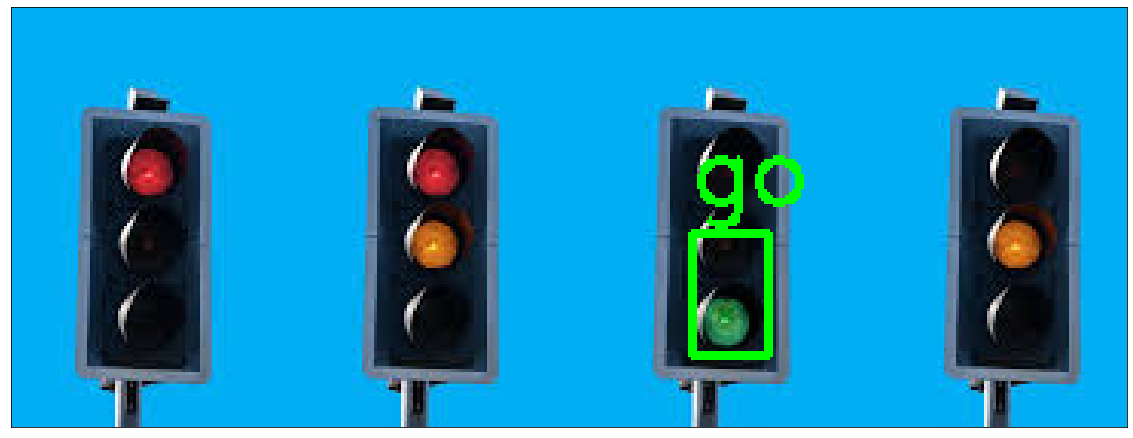

In [51]:
misc_traffic_light_images = ['uk_traffic_1.jpg', 'uk_traffic_2.jpg', 'uk_traffic_3.png', 'uk_traffic_4.jpeg']

to_tensor = torchvision.transforms.ToTensor()
for img_path in misc_traffic_light_images:
    imag = Image.open(img_path).convert("RGB")
    plot_detection(to_tensor(imag), model, 0.8, rect_th=2)


What this highlights is how the model has overfit to traffic lights at a distance 0 it can't detect when the traffic lights are close up.
For some scenarios, this might be acceptable. In a self driving car, for instance, the cameras will be mounted at fixed positions and the traffic lights are likely to be at a reasonable distance.

In some cases, the model doesn't do well with lens flare from the camera - a circular green lens flare occurs, and the model thinks it's a (albeit very small) green traffic light.

To extend this prototype, I'd like to do more hyperparameter tuning and get a greater variety of data.